In [4]:
import pickle
import numpy as np
import pyproj
import matplotlib.path as path
import s3fs
import zarr
import matplotlib.pyplot as plt
import scipy
from datetime import timedelta
from tqdm import tqdm
import xarray as xr
import re
import pandas as pd

# Select the file gathering your glacier boundaries

In [5]:
# Specify the file path
file_path = 'Gulkana.csv'

# Use numpy.genfromtxt() to read the CSV file
boundary_points = np.genfromtxt(file_path, delimiter=',', skip_header=1)[:,2:]

proj_points = 32606

# Reproject the coordinates of the RGI boundaries in the right projection
tform_map = pyproj.Transformer.from_crs(crs_from=proj_points, crs_to=4326, always_xy=True)
fx_map, fy_map = tform_map.transform(boundary_points[:,0], boundary_points[:,1])


# Create a Pandas DataFrame with X and Y coordinates
coords_map = pd.DataFrame({'X': list(fx_map[::50]), 'Y': list(fy_map[::50])})

In [6]:
import ipyleaflet as ipyl
import ipywidgets as ipyw
import json
import pandas as pd

# Create a Pandas DataFrame with X and Y coordinates
data = pd.DataFrame({'X': list(fx_map[::50]), 'Y': list(fy_map[::50])})

# Map and label widgets
map = ipyl.Map(center=(0, 0), zoom=2)
label = ipyw.Label(layout=ipyw.Layout(width="100%"))

# Create a list to store clicked URLs
urls = []

# geojson layer with hover handler
with open("catalog_v02.json") as f:
    geojson_data = json.load(f)

for feature in geojson_data["features"]:
    feature["properties"]["style"] = {
        "color": "grey",
        "weight": 1,
        "fillColor": "grey",
        "fillOpacity": 0.5,
    }

geojson_layer = ipyl.GeoJSON(data=geojson_data, hover_style={"fillColor": "red"})

def hover_handler(event=None, feature=None, id=None, properties=None):
    label.value = properties["zarr_url"]

def click_handler(event=None, feature=None, id=None, properties=None):
    zarr_url = properties.get("zarr_url", "N/A")
    urls.append(zarr_url)
    print(f"Clicked URL: {zarr_url}")
    print("All Clicked URLs:", urls)

geojson_layer.on_hover(hover_handler)
geojson_layer.on_click(click_handler)
map.add(geojson_layer)

# Add points from the DataFrame to the map
for index, row in data.iterrows():
    marker = ipyl.Marker(location=(row['Y'], row['X']))
    map.add_layer(marker)

# Enable zoom when scrolling with the mouse
map.scroll_wheel_zoom = True
ipyw.VBox([map, label])


Clicked URL: http://its-live-data.s3.amazonaws.com/datacubes/v02/N60W140/ITS_LIVE_vel_EPSG3413_G0120_X-2850000_Y550000.zarr
All Clicked URLs: ['http://its-live-data.s3.amazonaws.com/datacubes/v02/N60W140/ITS_LIVE_vel_EPSG3413_G0120_X-2850000_Y550000.zarr']
Clicked URL: http://its-live-data.s3.amazonaws.com/datacubes/v02/N60W140/ITS_LIVE_vel_EPSG3413_G0120_X-2950000_Y550000.zarr
All Clicked URLs: ['http://its-live-data.s3.amazonaws.com/datacubes/v02/N60W140/ITS_LIVE_vel_EPSG3413_G0120_X-2850000_Y550000.zarr', 'http://its-live-data.s3.amazonaws.com/datacubes/v02/N60W140/ITS_LIVE_vel_EPSG3413_G0120_X-2950000_Y550000.zarr']


# Select the datacubes overlapping your Glacier Of Interest (GOI)

### 1 left-click over each grey cube overlapping your GOI. If you make a mistake, simply restart the cell

# Velocity interpolation for a single point time series

Problem: Find a smooth regularly spaced timeseries of velocities given a set of average measurements of possibly overlapping and variable length time intervals

Formulate as inverse problem: Find a velocity vector $\mathbf{v}$ that minimizes the following functional:

$U(\mathbf{v},\lambda) = \|\mathbf{vInv}\|_r + \lambda \|A_{m}\mathbf{vInv} - \mathbf{vObs}\|$



Here $\mathbf{vInv}$ is a vector of speeds that we are solving for at a regular interval (for example daily)

$\|.\|_r$ is a roughness norm or a measure of the first derivative

$\lambda$ can be seen as a Lagrange multiplier (it enforces the condition in the expression behind it) or one can think of it as a relative weight of how well one wants to fit the data versus how smooth the resulting interpolated velocity should be.

$\mathbf{vObs}$ are the velocity measurements

$\mathbf{A_{m}}$ is an indexing matrix that specifies over which time interval a velocity was measured (and averages it appropriately).

For a simple example, assume you want daily velocities for 6 days, and you have a measurement of the average velocity from day 1 to day 4 ($d_1$) and from day 3 to day 5 ($d_2$). We then have

$$A_{m} = \begin{bmatrix}
		1/4 & 1/4 & 1/4 & 1/4 & 0 & 0 \\ 
		0 & 0 & 1/3 & 1/3 & 1/3 & 0
		\end{bmatrix}$$

The number of rows is equal to the number of measurements $N$ (same dimension as $\mathbf{vObs}$ and the number of columns $M$ is the same dimension as $\mathbf{vInv}$.

In order to regularize the matrix in time, we create a matrix of regularization $\mathbf{reg_{mat}}$ which dimensions are $(M-1)$ x $M$, for which each entry will be depending on the $\lambda$ term and the order of the term we apply the regularization to (approximation of finite differences).

For 1st derivative regularization: $f'(x) \approx \frac{f_{i+1} - f_{i}}{h}$ 

Which would result in: $$reg_{mat} = \begin{bmatrix}
										-\frac{\lambda}{h} & \frac{\lambda}{h} & 0 & 0 & 0 & 0 \\ 
										0 & -\frac{\lambda}{h} & \frac{\lambda}{h}& 0 & 0 & 0
										\end{bmatrix}$$

For 2nd derivative regularization: For 1st derivative regularization: $f''(x) \approx \frac{f_{i+2} - 2f_{i+1} + f_{i}}{h}$ 

Which would result in: $$reg_{mat} = \begin{bmatrix}
										\frac{\lambda}{h^{2}} & -2\frac{\lambda}{h^{2}} & \frac{\lambda}{h^{2}} & 0 & 0 & 0 \\ 
										0 & \frac{\lambda}{h^{2}} & -2\frac{\lambda}{h^{2}} & \frac{\lambda}{h^{2}} & 0 & 0
										\end{bmatrix}$$

And we finally obtain our main design matrix (with 2nd derivative), which is a concatenation of $A_{m}$ and $reg_{mat}$:

$$A_{reg} = \begin{bmatrix}				\\ & & A_{m} & & & \\ \\
										\frac{\lambda}{h^{2}} & -2\frac{\lambda}{h^{2}} & \frac{\lambda}{h^{2}} & 0 & 0 & 0 \\ 
										0 & \frac{\lambda}{h^{2}} & -2\frac{\lambda}{h^{2}} & \frac{\lambda}{h^{2}} & 0 & 0
										\end{bmatrix}$$

In which case we need to extend our vector $\mathbf{vObs}$:

$$\begin{bmatrix} v_{0} \\ v_{1} \\ ... \\ v_{n} \end{bmatrix} to \begin{bmatrix} v_{0} \\ v_{1} \\ ... \\ v_{n} \\ 0 \\ 0 \\ ... \\ 0 \end{bmatrix} $$

With as many the amount of 0s appended being $(M-1)$

The obtained velocity vector is then the size of the regular matrix in time. 
We can add a spatial regularization but it increases the computation time by 3. 

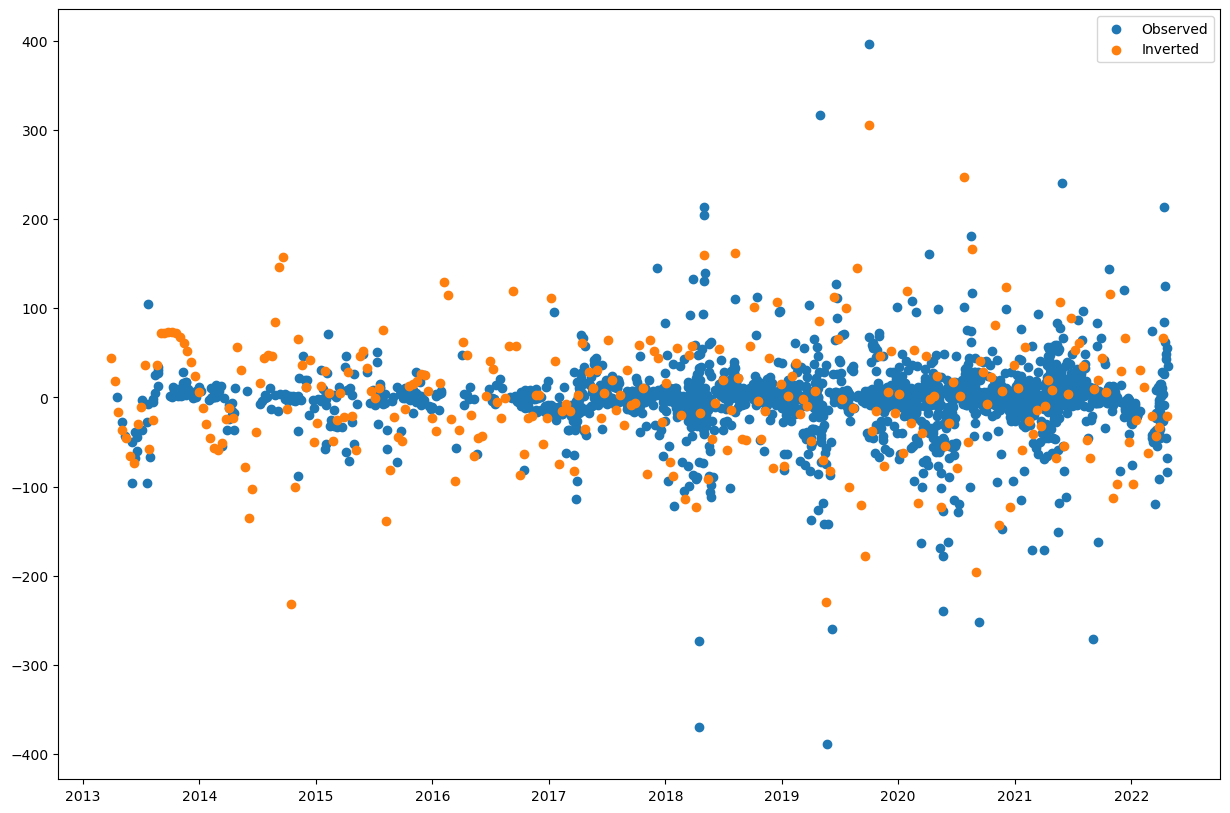

In [47]:
V = 500
c = 0

plt.figure(figsize=(15, 10))
test = data_dict[urls[c]]['zarr_store']['vx'][:, valid_idx[0][V], valid_idx[1][V]].astype(np.float32)
test[test<-25000] = np.nan
plt.scatter(data_dict[urls[c]]['zarr_store']['mid_date'][:], test, label='Observed')
plt.scatter(ind_tot, vxInv[:, y_matches[500], x_matches[500]], label='Inverted')
plt.legend()

In [44]:
y_matches.shape

(1122,)

## Get the points (to modify and implement with the ITS_LIVE notebook fetching the datacube's addresses)

In [7]:
# Gather the points on the boundary of the glacier (should later be implemented as a GUI loading the points of a glacier's periphery)
#boundary_points = pickle.load(open('boundary.p','rb'))

# Modify the urls so they can be opened by zarr (replace 'http' by 's3' and delete '.s3.amazonaws.com')
urls = [re.sub(r'http', 's3', url) for url in urls]
urls = [re.sub(r'\.s3\.amazonaws\.com', '', url) for url in urls]

# Create storing arrays for the coordinates on-glacier
X_valid = []
Y_valid = []
X_tot = []
Y_tot = []

# Create an empty directory to hold many variables all tied to the datacubes
data_dict = {}

# We iterate through the different datacubes so they can each have one instance of the variables below
for url in urls:
    zarr_store = None # To store the datacube's information and access its variables
    dates = None # To store the dates at which the inversion will give values
    A_m = None # 1st part of the design matrix
    reg_mat_Inv = None # Regularization in time, 2nd part of the design matrix
    mission = None # If you want to invert specifically for one mission in particular ('S1','L8','L9', etc...)
    index_sort = None # Indices representing the sorted dates (from older to most recent)
    inds_mission = None # Indices representing the sorted dates per mission chosen
    ind_tot = None # Indices representing the indices of the pixels on the GOI
    valid_idx = None # Easting and Northing values of the indices above
    
    # Create a dictionary entry for the URL with the desired subsets
    data_dict[url] = {
        'zarr_store': zarr_store,
        'dates': dates,
        'A_m': A_m,
        'reg_mat_Inv': reg_mat_Inv,
        'mission': mission,
        'index_sort': index_sort,
        'inds_mission': inds_mission,
        'dates': dates,
        'ind_tot': ind_tot,
        'valid_idx': valid_idx
    }


## Datacubes Extent and Point Validity

Designed to grab the extents of the datacubes, and determines which pixel belongs to the GOI. This way we do not lose time inverting for empty pixels.

In [8]:
def get_extents(url, X_tot, Y_tot, X_valid, Y_valid, data_dict, mission, lamb, derivative, day_interval):

    # Open the zarr files
    fs = s3fs.S3FileSystem(anon=True)
    store = zarr.open(s3fs.S3Map(url, s3=fs))
   
    # Update the dictionnary
    data_dict[url]['zarr_store'] = store

    # Get the cube's projection
    proj_cube = store.attrs['projection']

    # Load X and Y of the dataset
    X = store['x'][:]
    Y = store['y'][:]

    # Store the arrays in the total list
    X_tot.append(X)
    Y_tot.append(Y)

    # Load dimensions
    shape_arr = store['v'].shape
    
    # Create a grid from the cube's coordinates
    Xs,Ys = np.meshgrid(X, Y)
    X = np.vstack((Xs.ravel(),Ys.ravel())).T

    # Reproject the coordinates of the RGI boundaries in the right projection
    tform = pyproj.Transformer.from_crs(crs_from=proj_points, crs_to=int(proj_cube), always_xy=True)
    fx, fy = tform.transform(boundary_points[:,0], boundary_points[:,1])
    
    # Determine which pixel in the matrix is on the GOI
    p = path.Path(np.vstack((fx,fy)).T)
    glacier_mask = p.contains_points(X)
    glacier_mask = glacier_mask.reshape(shape_arr[1], shape_arr[2])

    # Grab the indices of the points inside the glacier
    idx_valid = np.array(np.where(glacier_mask==True))
    
    # Store the valid indices
    data_dict[url]['valid_idx'] = idx_valid
    
    # Store the coordinates of the valid Xs and Ys
    X_valid.append([Xs[idx_valid[0][i], idx_valid[1][i]] for i in range(len(idx_valid[0]))])
    Y_valid.append([Ys[idx_valid[0][i], idx_valid[1][i]] for i in range(len(idx_valid[0]))])
    
    return X_tot, Y_tot, X_valid, Y_valid

## Design Matrices

This function creates 1 design matrix per cube. Knowing that each cube has different time stamps (different image pairs), but the possible dates for the image pairs are the same for every pixel of the datacube, we can pre-compute 1 design-matrix for each cube. We will simply mask-out the rows that represent time steps for which our point being inverted does not have any value.

In [9]:
def design_matrices(url, mission, lamb, derivative, day_interval):

    # If you passed 'mission' as an argument, it grabs the appropriate values
    if mission:
        # Get the indices of the mission
        filt1 = np.where(data_dict[urls[url]]['zarr_store']['satellite_img1'][:] == mission)
        filt2 = np.where(data_dict[urls[url]]['zarr_store']['satellite_img2'][:] == mission)
        inds_mission = np.intersect1d(filt1[0],filt2[0])

        # Grab only the indices corresponding to the missions
        mid_dates = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['mid_date'][:], dtype='timedelta64[D]')[inds_mission]
        im1 = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['acquisition_date_img1'][:], dtype='timedelta64[D]')[inds_mission]
        im2 = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['acquisition_date_img2'][:], dtype='timedelta64[D]')[inds_mission]
    else:
        # If 'None' was passed as a mission argument, we grab all the available data.
        inds_mission = None
        mid_dates = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['mid_date'][:], dtype='timedelta64[D]')
        im1 = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['acquisition_date_img1'][:], dtype='timedelta64[D]')
        im2 = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['acquisition_date_img2'][:], dtype='timedelta64[D]')
    
    # Get some arrays
    index_sort = np.argsort(np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['mid_date'][:], dtype='timedelta64[D]'))
    mid_dates = mid_dates[index_sort]
    im1 = im1[index_sort]
    im2 = im2[index_sort]


    # Check which im is the smallest (first image, it changes depending on ITS_LIVE's version)
    if im2[0] < im1[0]:
        temp = im1
        im1 = im2
        im2 = temp


    # Create the date array with the new interval dates
    dates_nonum = np.arange(mid_dates[0], mid_dates[-1], timedelta(days=day_interval)).astype(np.datetime64)

    # Convert to numerical
    dates = (dates_nonum - np.datetime64('1970-01-01T00:00:00Z'))/np.timedelta64(1, 's')
    dt_start = (im1 - np.datetime64('1970-01-01T00:00:00Z'))/np.timedelta64(1, 's')
    dt_end = (im2 - np.datetime64('1970-01-01T00:00:00Z'))/np.timedelta64(1, 's')

    # --------------- DESIGN MATRICES --------------- 

    # Initialize matrix
    A_m = np.zeros((mid_dates.shape[0],dates.shape[0]))

    # We have to iterate through the satellite pairs that actually gave a measurement
    for j in range(1, len(mid_dates)):
    # current contents of your for loop

        # Find the middate that is the closest to dt_start (supequal)
        start = np.argmin(np.abs(dates-dt_start[j]))

        # Find the middate that is closest to dt_end (infequal)
        end = np.argmin(dt_end[j] - dates[dates <= dt_end[j]])

        # Divide 1 by the amount of middates between d_start and d_end 
        if end == A_m.shape[1]-1: # If the mid_date is at the end of the array (acquisition im2 equals last mid_date)
            A_m[j, start:] = 1/(1+A_m.shape[1]-start)
        else: # If the measurement is in A's bounds temporally (we can have a satellite pair with the 2nd pair being outside of our mid_dates)
            A_m[j, start:end+1] = 1/(1+end-start) # Attribute to each pixel in the timescale of the satellite pair, the 1/amount of pixel in the pairmid_dates.shape


    # Initialize regularization matrix
    if derivative == 1:
        reg_mat_Inv = np.zeros((A_m.shape[1] -1, A_m.shape[1]))

        for j in range(A_m.shape[1] -1):
            reg_mat_Inv[j, j] = -lamb/day_interval
            reg_mat_Inv[j, j+1] = lamb/day_interval

    elif derivative == 2:
        # Initialize 2nd derivative regularization matrix
        reg_mat_Inv = np.zeros((A_m.shape[1] -1, A_m.shape[1]))

        for j in range(A_m.shape[1] -2):
            reg_mat_Inv[j, j] = lamb/(day_interval**2)
            reg_mat_Inv[j, j+1] = -2*lamb/(day_interval**2)
            reg_mat_Inv[j, j+2] = lamb/(day_interval**2)
            
    data_dict[urls[url]]['A_m'] = A_m
    data_dict[urls[url]]['reg_mat_Inv'] = reg_mat_Inv
    data_dict[urls[url]]['mission'] = mission
    data_dict[urls[url]]['index_sort'] = index_sort
    data_dict[urls[url]]['inds_mission'] = inds_mission
    data_dict[urls[url]]['dates'] = dates_nonum
            
    return data_dict

## Inversion function

We input the observed velocities, the dictionnary of the datacube from which these velocities are taken from, and the no_data value of the velocities.
We reduce the shape of the design matrix in Y (rows) by squeezing-out the rows corresponding to dates at which the point we invert for does not have any values.


In [10]:
def Inv_reg(vObs, data, fillvalue):
 
    # Grab observed velocities
    vObs = vObs[data['index_sort']]
    
    # Filter out the missions we don't want
    if mission:
        vObs = vObs[data['inds_mission']]  
    
    # Mask the NaNs so we don't compute the inversion for empty rows
    mask = np.logical_not(np.equal(vObs, fillvalue))
    
    # Create a masked velocity vector
    vObs_masked = vObs[mask]
    
    # Append regularization terms to dObs
    vObs_masked= np.hstack((vObs_masked, np.zeros((data['reg_mat_Inv'].shape[0]))))
     
    # Assemble the design matrix
    A_des = np.vstack((data['A_m'][mask], data['reg_mat_Inv']))
    
    # Invert the velocities
    vInv = np.linalg.solve(A_des.T@A_des,A_des.T@vObs_masked)
    
    return vInv

# **Select Your Parameters**

In [11]:
mission = None # 'None' if you want all the data, 'S1' for Sentinel-1 only, 'L' for Landsat only, etc.. .
lamb = 10 # Smoothing coefficient: the higher the value, the more the inversion favors a smooth output. BAD for surging glaciers, GOOD for non-surging glaciers
derivative = 2 # Derivative degree for the inversion. Doesn't change much unless you have a specific reasong to choose 1 or 2 (1st or 2nd derivative)
day_interval = 12 # Amount of days in between each inversion value. The higher, the faster the inversion. But you also lose in temporal resolution. 12 here because Sentinel-1 repeat-time is 12.

### Get the extents of each datacube

In [12]:
for url in tqdm(range(len(urls))):
    X_tot, Y_tot, X_valid, Y_valid = get_extents(urls[url], X_tot, Y_tot, X_valid, Y_valid, data_dict, mission, lamb, derivative, day_interval)

100%|██████████| 2/2 [00:06<00:00,  3.12s/it]


### For each datacube's valid indices (on the GOI), get the corresponding coordinates in a layer that gathers all the GOI parts spread accross the datacubes

In [13]:
# Create Eastings and Northings arrays based on the Eastings and Northings of the datacubes
X_arr = np.unique(np.hstack(X_tot))
Y_arr = np.unique(np.hstack(Y_tot))

# Crop to the GOI (so we avoid over-filling our matrix with NaNs)
x_min = np.where(np.min(np.hstack(X_valid)) == X_arr)[0][0]
x_max = np.where(np.max(np.hstack(X_valid)) == X_arr)[0][0]
y_min = np.where(np.min(np.hstack(Y_valid)) == Y_arr)[0][0]
y_max = np.where(np.max(np.hstack(Y_valid)) == Y_arr)[0][0]


# And now search the indices corresponding to the coordinates 
x_matches = np.hstack([[np.where(i == X_arr[min(x_min-1, x_max+1):max(x_min-1, x_max+1)])[0][0] for i in row] for row in X_valid])
y_matches = np.hstack([[np.where(i == Y_arr[min(y_min-1, y_max+1):max(y_min-1, y_max+1)])[0][0] for i in row] for row in Y_valid])

# Create an array representing the glacier
template = np.zeros((len(Y_arr[min(y_min-1, y_max+1):max(y_min-1, y_max+1)]), len( X_arr[min(x_min-1, x_max+1):max(x_min-1, x_max+1)])))
template[y_matches, x_matches] = 1

Verify that the glacier looks like what we would expect

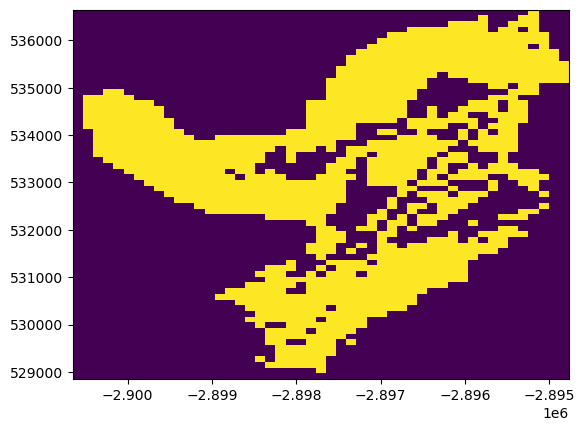

In [14]:
plt.pcolormesh(X_arr[x_min-1:x_max+1], Y_arr[y_min-1:y_max+1], template)

### Create the design matrices for each datacube

In [15]:
for i in tqdm(range(len(urls))):
    design_matrices(i, mission, lamb, derivative, day_interval)

  0%|          | 0/2 [00:00<?, ?it/s]/tmp/ipykernel_7356/2717921431.py:39: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  dates = (dates_nonum - np.datetime64('1970-01-01T00:00:00Z'))/np.timedelta64(1, 's')
/tmp/ipykernel_7356/2717921431.py:40: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  dt_start = (im1 - np.datetime64('1970-01-01T00:00:00Z'))/np.timedelta64(1, 's')
/tmp/ipykernel_7356/2717921431.py:41: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  dt_end = (im2 - np.datetime64('1970-01-01T00:00:00Z'))/np.timedelta64(1, 's')
100%|██████████| 2/2 [00:38<00:00, 19.06s/it]


### Gather the dates for each datacube. They might not always correspond.

In [16]:
# Get the total amount of temporal steps
ind_tot = []
for i in urls:
    ind_tot.append(data_dict[i]['dates'])

ind_tot = np.unique(np.hstack(ind_tot))

for i in urls:
    data_dict[i]['ind_tot'] = np.array([np.where(c == ind_tot)[0][0] for c in data_dict[urls[0]]['dates']])

### Calculate the point-inversion for all the GOI pixels in the datacubes for Vx and Vy.

In [17]:
vxInv = np.zeros((len(ind_tot), template.shape[0], template.shape[1]))
vyInv = np.zeros((vxInv.shape))

# Define the total number of iterations
total_iterations = len(y_matches)

# Create a tqdm object with dynamic_ncols=False to suppress intermediate updates
# Create a tqdm object with a larger mininterval to suppress intermediate updates
progress_bar = tqdm(total=total_iterations, dynamic_ncols=False, mininterval=1.0)


i = 0
for c in range(len(urls)):
    valid_idx = data_dict[urls[c]]['valid_idx']
    fillvx = data_dict[urls[c]]['zarr_store']['vx'].fill_value
    fillvy = data_dict[urls[c]]['zarr_store']['vy'].fill_value
    
    for V in range(len(valid_idx[0])):
        vxObs = data_dict[urls[c]]['zarr_store']['vx'][:, valid_idx[0][V], valid_idx[1][V]]
        vyObs = data_dict[urls[c]]['zarr_store']['vy'][:, valid_idx[0][V], valid_idx[1][V]]
        vxInv[data_dict[urls[c]]['ind_tot'], y_matches[i], x_matches[i]] = Inv_reg(vxObs, data_dict[urls[c]], fillvx)
        vyInv[data_dict[urls[c]]['ind_tot'], y_matches[i], x_matches[i]] = Inv_reg(vyObs, data_dict[urls[c]], fillvy)
        
        i += 1
        progress_bar.update(1)  # Update the progress bar

# Close the progress bar
progress_bar.close()
        

100%|██████████| 1122/1122 [08:37<00:00,  2.17it/s]


### Save the results in a netcdf file

In [18]:
# Create a new dataset with vx and vy, using attributes from 'ds'
new_ds = xr.Dataset(
    {
        "vx": (["time", "y", "x"], vxInv),
        "vy": (["time", "y", "x"], vyInv),
    },
    coords={
        "time": ind_tot,
        "x": X_arr[x_min-1:x_max+1],
        "y": Y_arr[y_min-1:y_max+1],
    },
    attrs=data_dict[urls[0]]['zarr_store'].attrs,
).chunk({'time': 1, 'x': 100, 'y': 100})

from dask.diagnostics import ProgressBar
write_job = new_ds.to_netcdf('Inverted_Cube.nc', compute=False)
with ProgressBar():
    print(f"Writing to {'Inverted_Cube.nc'}")
    write_job.compute()

Writing to Inverted_Cube.nc
[########################################] | 100% Completed | 606.20 ms


In [19]:
test = xr.open_dataset('Inverted_Cube.nc')

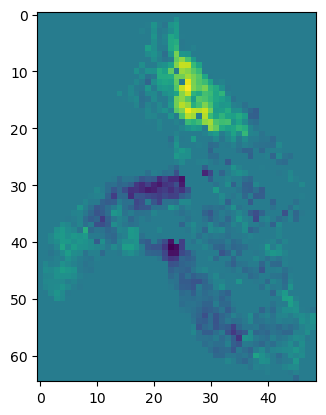

In [20]:
plt.imshow(np.nanmean(test.vx, axis=0))